<a href="https://colab.research.google.com/github/haein0224/Study_machinelearning/blob/main/%EC%9D%8C%EC%84%B1%EB%B6%84%EB%A5%98%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 분석 환경 준비

In [1]:
# 오디어 전처리를 위한 라이브러리 
import librosa
import librosa.display as dsp
from IPython.display import Audio

In [2]:
# 데이터 전처리를 위한 라이브러리
import pandas as pd
import numpy as np
import os
from tqdm import tqdm # 진행 상황 확인을 위해 사용되는 모듈

In [3]:
# random seed의 고정
import random

def seed_everything(seed) : 
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)

seed_everything(929)

## 2. 데이터 불러오기

In [4]:
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/user_data/train.csv")
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


In [5]:
train.info()
# 레이블이 int 타입으로 되어있음 확인

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  400 non-null    object
 1   label      400 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ KB


## 3. 데이터 전처리
## 3.1 데이터셋 구성
- 소리는 기본 적으로 특정 주파수를 가지는 sin 함수들의 합
- 아날로그 데이터를 디지털 신호로 변환해야함 -> librosa 라이브러리를 사용

In [6]:
data, sample_rate = librosa.load('/content/drive/MyDrive/Colab Notebooks/user_data/train/001.wav', sr=16000)
print('sample_rate :', sample_rate, ', audio shape : ',data.shape)
print('length : ', data.shape[0]/float(sample_rate), 'secs')

# sr  = 16000 : 1초당 16000Hz 주파수 (즉, 16000개)의 샘플을 가지고 있는 데이터라는 의미
# 이를 이용해 오디오의 길이 계산 가능

sample_rate : 16000 , audio shape :  (10192,)
length :  0.637 secs


In [7]:
# 디지털 신호와 라벨을 포함함 train_wav 데이터 프레임 생성

def train_dataset() :
  folder = '/content/drive/MyDrive/Colab Notebooks/user_data/train/'
  dataset = []
  for file in tqdm(os.listdir(folder), colour='green') : # 진행상황 확인용 (폴더 안의 파일을 모두 읽어오는 것을 기준으로 진행률 체크)
    if 'wav' in file : # 확장자가 wav인 파일에 대해
      abs_file_path = os.path.join(folder, file) # 경로 지정
      data, sr = librosa.load(abs_file_path, sr = 16000)
      class_label = int(train[train.file_name == file].label) # 파일명과 매치되는 label 저장
      dataset.append([data, class_label])

  print('Dataset 생성 완료')
  return pd.DataFrame(dataset, columns=['data','label'])


                                   

In [8]:
train_wav = train_dataset()

100%|██████████| 400/400 [00:24<00:00, 16.20it/s]

Dataset 생성 완료


In [9]:
train_wav.head()

,data,label
0,"[0.00011985076, 0.00016174652, 0.00017246709, ...",9
1,"[1.2653453e-05, 2.3892262e-05, -7.51332e-06, 4...",0
2,"[9.2610695e-05, 0.00018442213, 0.00021447388, ...",7
3,"[-0.00043892296, -0.00073743664, -0.0006132907...",8
4,"[-4.289015e-05, 9.891299e-05, 2.6636611e-05, 0...",4


 ## 3.2 음성 데이터 특징 추출
입력된 신호에서 실제 유용한 소리의 특징을 추출

- 퓨리에 변환 : 길이에 대한 부분이 결여
- MFCC (Mel-frequency cepstral coefficients) : 음성데이터를 특징 벡터화 해주는 알고리즘으로 입력된 소리 전체가 아니라 구간으로 나누고, 구간에 대한 스펙트럼을 분석 및 퓨리에 변환을 하는 방식 -> librosa.feature.mfcc(wav) 메서드 사용

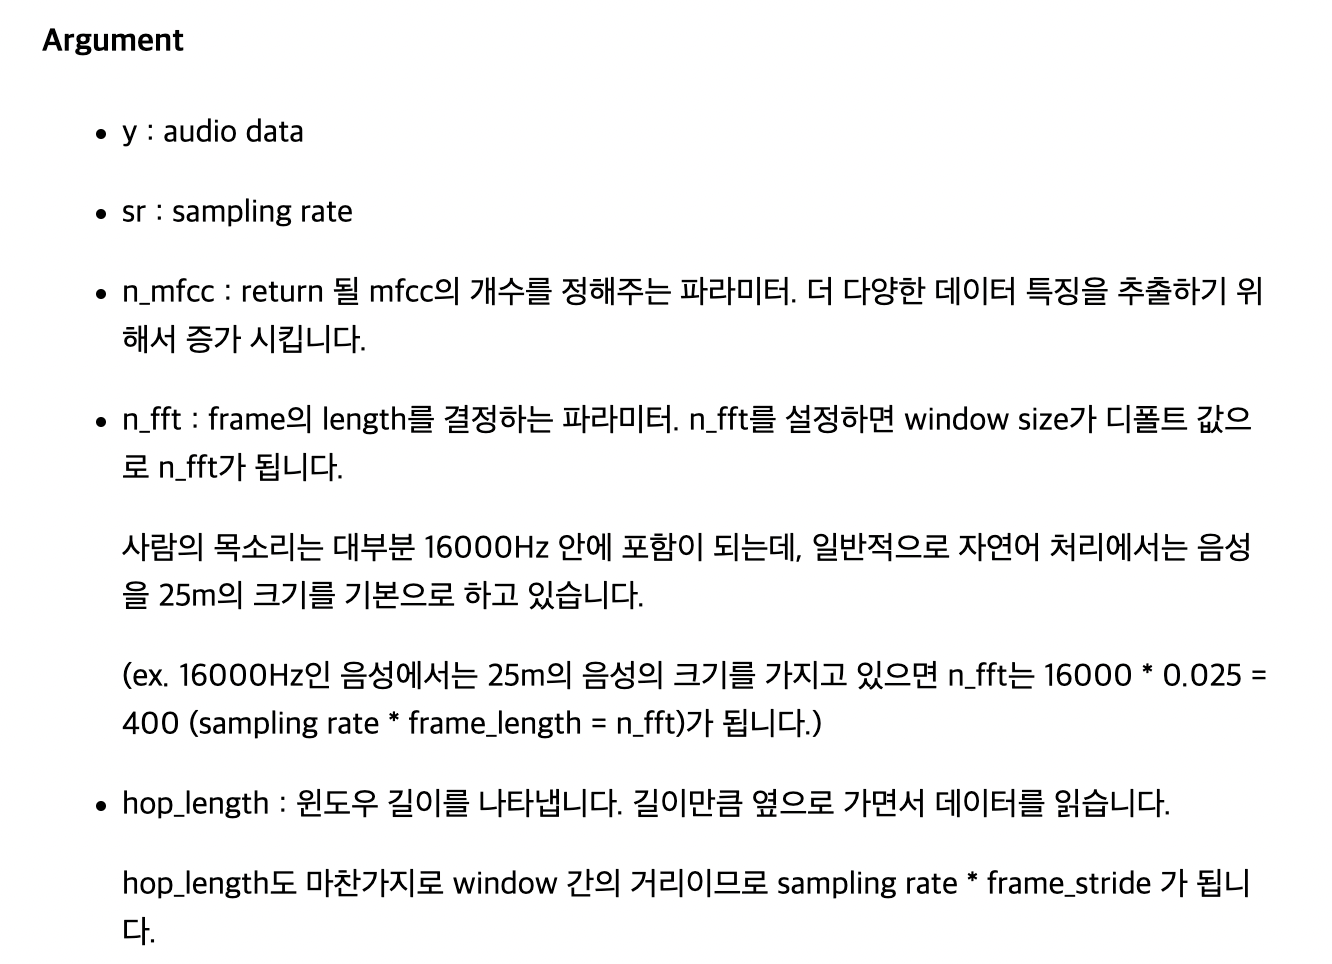

In [10]:
def extract_features(file) :
  audio, sr = librosa.load(file, sr = 16000)
  extracted_features = librosa.feature.mfcc(y=audio, # 데이터를 (40,20)으로 디지털 변환함(각각은 20개의 원소가 들어있는 리스트)
                                            sr=sr,
                                            n_mfcc=40) # 더 다양한 특징을 추출하기 위해 증가시킴
  extracted_features = np.mean(extracted_features.T, axis=0) # transpose 해서 axis = 0 방향으로 평균 계산
  return extracted_features


In [34]:
extract_features('/content/drive/MyDrive/Colab Notebooks/user_data/train/001.wav')

array([-5.4157184e+02,  1.0199717e+02, -1.0018574e+01,  4.5054619e+01,
        7.3112831e+00,  1.0971639e+01, -1.2032939e+01, -5.8687963e+00,
       -1.8881397e+00,  4.2930884e+00, -8.1847525e+00, -2.3072267e+00,
       -9.1721897e+00,  1.4182716e+01, -1.2839543e+01, -3.1000307e+00,
       -3.0502689e+00, -2.1911802e+00, -6.2639456e+00, -5.1691580e+00,
       -1.3974123e+01,  3.3810470e+00, -6.9977813e+00,  3.7736315e-01,
       -4.4287405e+00,  1.0799457e+00, -1.3639281e+00,  4.2418456e+00,
        2.3687005e+00,  2.8972096e+00,  2.6670651e+00,  1.8590584e+00,
       -3.8219376e+00, -1.6171500e-01, -1.4186366e+00, -4.1422081e+00,
       -5.3374414e+00, -9.9907333e-01, -3.3392251e+00, -4.2987290e-01],
      dtype=float32)

In [12]:
# 체크용 1
audio, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/user_data/train/001.wav', sr=16000)
extracted_features = librosa.feature.mfcc(y=audio, 
                                            sr=sr,
                                            n_mfcc=40)

In [28]:
# 체크용 2
np.mean(extracted_features[0:3].T, axis=0) # 결과는 열 개수만큼 나옴

array([-541.57184 ,  101.99717 ,  -10.018574], dtype=float32)

In [30]:
# 체크용 3
print(extracted_features[0:3].shape)
print(extracted_features[0:3].T.shape)


(3, 20)
(20, 3)


In [33]:
# 체크용 4
extracted_features[0:3].T

array([[-747.99347  ,   59.984238 ,   30.550184 ],
       [-748.7608   ,   62.617714 ,   29.19136  ],
       [-712.02484  ,   98.68237  ,   51.052963 ],
       [-617.0448   ,  136.10788  ,   30.360008 ],
       [-488.32626  ,  131.29298  ,   -8.9365   ],
       [-408.64337  ,  102.005905 ,  -24.120129 ],
       [-374.19037  ,  100.72002  ,  -54.61741  ],
       [-374.3358   ,  114.12147  ,  -69.59209  ],
       [-362.77393  ,  118.62189  ,  -74.39027  ],
       [-356.2321   ,  107.64737  ,  -71.61966  ],
       [-370.72696  ,   91.20331  ,  -60.690105 ],
       [-412.5123   ,   89.065994 ,  -48.86167  ],
       [-458.46768  ,   95.86702  ,  -32.695183 ],
       [-494.28482  ,  106.53164  ,  -17.369328 ],
       [-546.5862   ,  115.65152  ,   -2.2593632],
       [-606.80536  ,  116.90495  ,   19.737144 ],
       [-645.29895  ,  117.1206   ,   28.274921 ],
       [-677.3151   ,  106.704315 ,   24.670193 ],
       [-704.38495  ,   91.802414 ,   24.805569 ],
       [-724.72833  ,   77.2897

In [35]:
## train 셋 데이터 전체를 MFCC 알고리즘을 이용해 특징 추출

def preprocess_train_dataset(data) :
  mfccs = []
  for i in data :
    extracted_features = librosa.feature.mfcc(y=i,
                                              sr=16000,
                                              n_mfcc = 40)
    extracted_features = np.mean(extracted_features.T, axis=0)
    mfccs.append(extracted_features)

  return mfccs

mfccs = preprocess_train_dataset(train_wav.data)
mfccs = np.array(mfccs)

In [43]:
mfccs

array([[-5.4157184e+02,  1.0199717e+02, -1.0018574e+01, ...,
        -9.9907333e-01, -3.3392251e+00, -4.2987290e-01],
       [-6.0275000e+02,  1.0384115e+02, -2.7612200e+00, ...,
        -6.2690437e-01, -2.5183797e+00,  1.0917178e+00],
       [-6.2317560e+02,  6.1793907e+01,  3.6873024e+01, ...,
         3.7200587e+00, -2.7225404e+00,  8.9224957e-02],
       ...,
       [-6.2541888e+02,  6.6935570e+01,  2.1939228e+01, ...,
         2.8762165e-01, -2.5981746e+00, -3.6949081e+00],
       [-5.1473218e+02,  6.9641624e+01, -2.2522993e+01, ...,
        -8.1666964e-01, -7.3845682e+00, -2.4838426e+00],
       [-5.7801672e+02,  8.9649864e+01,  6.7791176e+00, ...,
         3.5183573e+00, -6.8778259e-01,  2.9434044e+00]], dtype=float32)

In [42]:
# 체크용
train_wav # 위에서 전체를 불러와서 해당 데이터 프레임으로 만들었음

,data,label
0,"[0.00011985076, 0.00016174652, 0.00017246709, ...",9
1,"[1.2653453e-05, 2.3892262e-05, -7.51332e-06, 4...",0
2,"[9.2610695e-05, 0.00018442213, 0.00021447388, ...",7
3,"[-0.00043892296, -0.00073743664, -0.0006132907...",8
4,"[-4.289015e-05, 9.891299e-05, 2.6636611e-05, 0...",4
...,...,...
395,"[0.00022290103, 0.00040377295, 0.0003870582, 0...",6
396,"[-5.592337e-06, 7.6186375e-06, -4.226782e-07, ...",7
397,"[9.129914e-05, 0.000138045, 0.00014511817, 0.0...",7
398,"[-0.00026867507, -0.00042158956, -0.0003178061...",5


## 4. 변수 및 모델 정의

- 음성 특징 데이터 : x, label : y
- 60:40 = train : valid 로 구분할 예정

In [44]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(mfccs, train_wav.label, test_size = 0.4)

In [45]:
print('학습시킬 train 셋 :', train_X.shape, train_y.shape )
print('검증할 val 셋 : ', test_X.shape, test_y.shape)

학습시킬 train 셋 : (240, 40) (240,)
검증할 val 셋 :  (160, 40) (160,)


## 5. 렌덤 포레스트 모델 학습
rf_classifier를 사용

In [46]:
from sklearn.ensemble import RandomForestClassifier

# 모델 선언
model = RandomForestClassifier()

# 모델 학습
model.fit(train_X, train_y)

RandomForestClassifier()

In [47]:
# 모델 성능 확인
import numpy as np

def ACCURACY(true, pred) :
  score = np.mean(true == pred) # 비율(%)로 나타내기 위해 mean 사용
  return score

In [49]:
# 모델의 예측값과 실제 값 비교하기
prediction = model.predict(test_X)

score = ACCURACY(test_y, prediction)

print(f'모델의 정확도는 {score*100:.2f}%입니다.')

모델의 정확도는 73.12%입니다.


## 6. test.csv 분류하기

In [51]:
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/user_data/test.csv")
test.head()

,file_name
0,003.wav
1,008.wav
2,010.wav
3,015.wav
4,024.wav


In [55]:
def test_dataset() :
  folder = '/content/drive/MyDrive/Colab Notebooks/user_data/test/'
  dataset = []
  for file in tqdm(os.listdir(folder), colour='blue') :
    if 'wav' in file :
      abs_file_path = os.path.join(folder,file)
      data, sr = librosa.load(abs_file_path, sr = 16000)
      dataset.append([data, file])

  print('dataset 생성 완료')
  return pd.DataFrame(dataset, columns=['data', 'file_name'])

In [66]:
test_wav = test_dataset()

100%|██████████| 200/200 [00:07<00:00, 27.40it/s]

dataset 생성 완료


In [57]:
test_wav.head()

,data,file_name
0,"[0.0002570461, 0.00046987124, 0.00042816417, 0...",079.wav
1,"[6.990338e-05, 0.000105007304, 8.3985695e-05, ...",063.wav
2,"[0.00027645202, 0.00047594117, 0.0004510493, 0...",010.wav
3,"[-6.177885e-06, -2.8552844e-05, 4.7127953e-05,...",072.wav
4,"[0.00021518696, 0.00039842026, 0.00028533765, ...",078.wav


In [67]:
mfccs_2 = preprocess_train_dataset(test_wav.data)
mfcc_2 = np.array(mfccs_2)

In [68]:
# validset 없이 전체로 모델 학습

model = RandomForestClassifier()

model.fit(mfccs, train_wav.label) # train 전체로 학습

prediction = model.predict(mfccs_2) # test 셋에 대해 예측 진행

test_wav['label'] = prediction # 기존 test 셋에 대한 정보 프레임에 prediction 붙여주기

In [65]:
test_wav.head()

,data,file_name,laebl,label
0,"[0.0002570461, 0.00046987124, 0.00042816417, 0...",079.wav,9,2
1,"[6.990338e-05, 0.000105007304, 8.3985695e-05, ...",063.wav,2,2
2,"[0.00027645202, 0.00047594117, 0.0004510493, 0...",010.wav,3,3
3,"[-6.177885e-06, -2.8552844e-05, 4.7127953e-05,...",072.wav,7,7
4,"[0.00021518696, 0.00039842026, 0.00028533765, ...",078.wav,0,0


In [73]:
testset = test_wav[['file_name','label']] # 두개 열만 가져오기

pred_df = testset.copy()
pred_df = pred_df.sort_values(by = [pred_df.columns[0]], ascending=True).reset_index(drop=True) # file_name을 기준으로 정렬
pred_df.head()

,file_name,label
0,003.wav,0
1,008.wav,9
2,010.wav,3
3,015.wav,3
4,024.wav,2


In [74]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/user_data/sample_submission.csv')
submission['label'] = pred_df['label']
submission.head()

,file_name,label
0,003.wav,0
1,008.wav,9
2,010.wav,3
3,015.wav,3
4,024.wav,2


In [76]:
# 파일 내보내기
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/user_data/submit.csv', index = False)

## 핸즈온 머신러닝에서 썼던 코드 그대로 적용
- 파라미터 튜닝 등 전혀 적용 x
- log_clf, xgb_clf, rnd_clf 세가지 voting 해서 사용했을 때 publin score 0.7 나옴

In [77]:
### 연습용
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

In [78]:
# 각 분류기 세팅
log_clf = LogisticRegression(solver='liblinear')
rnd_clf = RandomForestClassifier(n_estimators=10)
#svm_clf = SVC(gamma='auto')
svm_clf = SVC(kernel='rbf', gamma='auto', probability=True)
xgb_clf = xgb.XGBClassifier()

In [80]:
svm_clf.fit(train_X, train_y)
log_clf.fit(train_X, train_y)
rnd_clf.fit(train_X, train_y)
xgb_clf.fit(train_X, train_y)

XGBClassifier(objective='multi:softprob')

In [81]:
svm_pred = svm_clf.predict(test_X)
log_pred = log_clf.predict(test_X)
rnd_pred = rnd_clf.predict(test_X)
xgb_pred = xgb_clf.predict(test_X)

svm_score = ACCURACY(test_y, svm_pred)
log_score = ACCURACY(test_y, log_pred)
rnd_score = ACCURACY(test_y, rnd_pred)
xgb_score = ACCURACY(test_y, xgb_pred)

print(f'svm 모델의 정확도는 {svm_score*100:.2f}%입니다.')
print(f'log 모델의 정확도는 {log_score*100:.2f}%입니다.')
print(f'rnd 모델의 정확도는 {rnd_score*100:.2f}%입니다.')
print(f'xgb 모델의 정확도는 {xgb_score*100:.2f}%입니다.')

svm 모델의 정확도는 6.25%입니다.
log 모델의 정확도는 68.12%입니다.
rnd 모델의 정확도는 55.62%입니다.
xgb 모델의 정확도는 68.12%입니다.


In [82]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier # 결정트리 한가지 알고리즘을 이용해 앙상블

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500, # 총 500개의 예측기를 생성해 앙상블 진행
    max_samples = 100, bootstrap=True, n_jobs = -1 ) # n_jobs : 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정함 (-1로 지정하는 경우 가용한 모든 코어를 사용)

bag_clf.fit(train_X, train_y)
y_pred = bag_clf.predict(test_X)

accuracy_score(test_y, y_pred)

0.70625

In [86]:
# soft 간접투표를 이용하는 경우
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('xgb', xgb_clf)], # ('svc', svm_clf)
    voting = 'soft')
voting_clf.fit(train_X, train_y)


VotingClassifier(estimators=[('lr', LogisticRegression(solver='liblinear')),
                             ('rf', RandomForestClassifier(n_estimators=10)),
                             ('xgb',
                              XGBClassifier(objective='multi:softprob'))],
                 voting='soft')

In [87]:
# 각 분류기의 정확도 확인

for clf in (log_clf, rnd_clf, voting_clf, xgb_clf) :
  clf.fit(train_X, train_y)
  y_pred = clf.predict(test_X)
  print(clf.__class__.__name__, accuracy_score(test_y, y_pred))

  # Voting classifier의 정확도가 더 높음!

LogisticRegression 0.68125
RandomForestClassifier 0.4875
VotingClassifier 0.70625
XGBClassifier 0.68125


In [93]:
voting_clf.fit(mfccs, train_wav.label)

prediction = voting_clf.predict(mfccs_2) # test 셋에 대해 예측 진행

test_wav['label'] = prediction 

In [94]:
test_wav.head()

,data,file_name,label
0,"[0.0002570461, 0.00046987124, 0.00042816417, 0...",079.wav,1
1,"[6.990338e-05, 0.000105007304, 8.3985695e-05, ...",063.wav,2
2,"[0.00027645202, 0.00047594117, 0.0004510493, 0...",010.wav,3
3,"[-6.177885e-06, -2.8552844e-05, 4.7127953e-05,...",072.wav,7
4,"[0.00021518696, 0.00039842026, 0.00028533765, ...",078.wav,3


In [95]:
testset = test_wav[['file_name','label']] # 두개 열만 가져오기

pred_df = testset.copy()
pred_df = pred_df.sort_values(by = [pred_df.columns[0]], ascending=True).reset_index(drop=True) # file_name을 기준으로 정렬
pred_df.head()

,file_name,label
0,003.wav,0
1,008.wav,1
2,010.wav,3
3,015.wav,3
4,024.wav,2


In [97]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/user_data/sample_submission.csv')
submission['label'] = pred_df['label']
submission.head()

,file_name,label
0,003.wav,0
1,008.wav,1
2,010.wav,3
3,015.wav,3
4,024.wav,2


In [98]:
# 파일 내보내기
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/user_data/submit1.csv', index = False)

# public score : 0.7 나옴